In [ ]:
! git clone https://github.com/Shiroiii/Helper_AI_Code

Cloning into 'Helper_AI_Code'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 66 (delta 29), reused 50 (delta 19), pack-reused 6
Unpacking objects: 100% (66/66), done.


In [ ]:
import sys
sys.path.append("/content/Helper_AI_Code/sports_helper")

In [ ]:
import torch
from torch import nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
from engine import train, eval
from data_setup import data_setup
from model_builder import create_vgg11, create_effb0

In [ ]:
BATCH_SIZE = 128
EPOCHS = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [ ]:
train_root = "/content/drive/MyDrive/ML_Data/Sports/train"
val_root = "/content/drive/MyDrive/ML_Data/Sports/valid"
test_root = "/content/drive/MyDrive/ML_Data/Sports/test"
pred = "/content/drive/MyDrive/ML_Data/Sports/'images to predict'"

In [ ]:
effb0, eff_transforms = create_effb0(device=DEVICE)

In [ ]:
train_set, train_loader, class_map = data_setup(dir=train_root, transforms=eff_transforms, batch_size=BATCH_SIZE)
val_set, val_loader, _ = data_setup(dir=val_root, transforms=eff_transforms, batch_size=BATCH_SIZE)

In [ ]:
train(model=effb0, train_dataloader=train_loader, test_dataloader=val_loader, optimizer=torch.optim.Adam(effb0.parameters(), lr=1E-3), loss_fn=nn.CrossEntropyLoss(), device=DEVICE, epochs=EPOCHS)

In [ ]:
vgg11, vgg_transforms = create_vgg11(device=DEVICE)

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


[INFO] Created new VGG11 model


In [ ]:
v_train_set, v_train_loader, class_map = data_setup(dir=train_root, transforms=vgg_transforms, batch_size=BATCH_SIZE)
v_val_set, v_val_loader, _ = data_setup(dir=val_root, transforms=vgg_transforms, batch_size=BATCH_SIZE)

In [ ]:
train(model=vgg11, train_dataloader=v_train_loader, test_dataloader=v_val_loader, optimizer=torch.optim.Adam(vgg11.parameters(), lr=1E-3), loss_fn=nn.CrossEntropyLoss(), device=DEVICE, epochs=EPOCHS)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5572 | test_loss: 0.4678 | train_acc: 0.6583 | test_acc: 0.8714
[INFO] Saving model to: model_params/VGG11.pth.tar
Epoch: 2 | train_loss: 0.1025 | test_loss: 0.3655 | train_acc: 0.9719 | test_acc: 0.9056
Epoch: 3 | train_loss: 0.0515 | test_loss: 0.3976 | train_acc: 0.9889 | test_acc: 0.9056
Epoch: 4 | train_loss: 0.0375 | test_loss: 0.3777 | train_acc: 0.9933 | test_acc: 0.9052
Epoch: 5 | train_loss: 0.0344 | test_loss: 0.4797 | train_acc: 0.9942 | test_acc: 0.8815


{'train_loss': [1.5572186858854562,
  0.10249016991877388,
  0.051473576843164094,
  0.0375042870927985,
  0.03444706237924973],
 'train_acc': [0.6582526702269692,
  0.9718687416555407,
  0.9888914385847797,
  0.9932827102803738,
  0.9942318925233645],
 'test_loss': [0.46784166991710663,
  0.36550242081284523,
  0.3976065665483475,
  0.3777422569692135,
  0.479728102684021],
 'test_acc': [0.8713631465517242,
  0.9055765086206897,
  0.9055765086206897,
  0.9051724137931034,
  0.8815328663793103]}

In [ ]:
v_train_set.classes

In [ ]:
def Predict(model:nn.Module, filepath:str, modelpath:str):
  best_model_state = torch.load(f"./model_params/{modelpath}")#["network_params"]
  model.load_state_dict(best_model_state)
  print("[INFO] Model Parameters have been loaded successfully")
  img = Image.open(filepath)
  transform = transforms.ToTensor()
  x = vgg_transforms(img)
  # x = transform(img)
  # x = vgg_transforms(x)
  pred = model(x.unsqueeze(dim=0).to(DEVICE)).to(DEVICE)
  lbl_pred_class = torch.argmax(pred, dim=1)
  pred_label = v_train_set.classes[lbl_pred_class]
  # img.permute(1, 2, 0)
  # plt.imshow(x.detach().cpu().permute(1, 2, 0))
  plt.imshow(img)
  plt.title(f"{pred_label}")
  

[INFO] Model Parameters have been loaded successfully


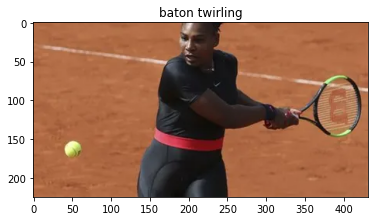

In [ ]:
Predict(model=vgg11, filepath="/content/tennis1.webp", modelpath="/VGG11.pth.tar")

In [ ]:
v_test_set, v_test_loader, _ = data_setup(dir=test_root, transforms=vgg_transforms, batch_size=BATCH_SIZE)

In [ ]:
def eval(model:nn.Module, loss:nn.Module, testDataloader: torch.utils.data.DataLoader, device:torch.device, filepath:str) -> dict:
    best_model_state = torch.load(f"./model_params/{filepath}")#["network_params"]
    model.load_state_dict(best_model_state)
    print("[INFO] Model Parameters have been loaded successfully")
    result = dict()

    model.eval()
    with torch.inference_mode():
        test_loss, test_acc = 0, 0
        for test_images, test_labels in testDataloader:
            test_images, test_labels = test_images.to(
                device), test_labels.to(device)

            test_pred = model(test_images)
            tloss = loss(test_pred, test_labels)
            test_loss += tloss

            lbl_pred_class = torch.argmax(test_pred, dim=1)
            test_acc += (lbl_pred_class == test_labels).sum().item() / len(test_pred)

        result["model"] = model.name
        result["loss"] = round((test_loss / len(testDataloader)).item(), 3)
        result["accuracy"] = round((test_acc / len(testDataloader)), 3)

    return result


In [ ]:
eval(model=vgg11, loss=nn.CrossEntropyLoss(), testDataloader=v_test_loader, device=DEVICE, filepath="/VGG11.pth.tar")

[INFO] Model Parameters have been loaded successfully


{'model': 'VGG11', 'loss': 0.432, 'accuracy': 0.889}